#**Process results LRC**
This notebook is devoted to process the report files generated by the scripts used for Lexical Relation Classification (LRC) and graded Lexical Entailment (LE). The intend is to generate a dataframe to visualize the results for our models/templates, and compare with SoTA results.

To reproduct the results in the paper with other result files, change the variables in a bellow cell that contains:

```
# folder with all datasets
DIR_DATASETS = '/content/datasets/'
# folder with the results
DIR_RESULTS = '/content/results/'
LIST_DIR_RES = [DIR_RESULTS + 'K_H+N/',
                DIR_RESULTS + 'BLESS/',
                DIR_RESULTS + 'EVALution/',
                DIR_RESULTS + 'ROOT09/',
                DIR_RESULTS + 'CogALexV/',
                DIR_RESULTS + 'hyperlex/results_hyperlex_lexical_split/',
                DIR_RESULTS + 'hyperlex/results_hyperlex_random_split/'
                ]
```


In [ ]:
!curl -L -O 'https://raw.github.com/sid-unizar/LRC/main/datasets/datasets.zip'
!unzip -o datasets.zip
!curl -L -O 'https://raw.github.com/sid-unizar/LRC/main/scripts/scripts.zip'
!unzip -o scripts.zip

In [ ]:
# download our results. Due to file size limitations, the results are download from google drive
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FzIGKGjbrFU_mdaJhEsCkk3FCYeQL6Ju" -O results.zip && rm -rf /tmp/cookies.txt
!unzip -o results.zip

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


###**LRC task: BLESS, K&H+N, ROOT9, EVALution and CogALexV datasets**

Lexical relation classification is the task of predict the lexical relation among two words, such as *(horse,animal) - hyponymy*.

####**Models in the literature: baselines**
The reported results in the literature for BLESS, K&H+N, ROOT9 and EVALution datasets are precision, recall and f1-score, weighted by the support of the labels. We have collected the results for the following models:
 - [LexNET](https://aclanthology.org/W16-5304/) (2016)
 - [SphereRE](https://aclanthology.org/P19-1169/) (2019)
 - [KEML](https://arxiv.org/abs/2002.10903) (2020)
 - [RelBERT](https://arxiv.org/abs/2110.15705) (2021)

As far as our knowneldge, these are the last SoTA models.

The reported results for CogALexV dataset are different. This dataset comes from the [CogALexV shared task (subtask 2)](https://sites.google.com/site/cogalex2016/home/shared-task) and it is well defined what results must be reported. In this dataset, there are five labels, including "RANDOM". The report results are the f1-scores for the four labels that are not the "RANDOM" one, and the weighted f1-score by the support of these four labels.

####**How the baseline results are collected**
We collect the results from the regarding papers.
The reported results in RelBERT paper do not contain precision and recall values, only micro and macro f1 average, i.e., the accuracy (micro) and the average of the f1-scores (macro) for all labels, repectively.  We have calculated the weighted f1-scores for RelBERT with the data (table 4) in the paper.


####**Our proposal for LRC**
We fine-tune a pretrained language model (as BERT or RoBERTa) feeding the model with a verbalization of the two words by means of a template (see in a bellow cell the variables `models2abrev` and `templates2abrev` for the chosen models and templates). We need the following components:
1. A pretrained language model (PTLM) $M$ and its token vocabulary $V_M$;
2. A training set ${\cal T}=\{(\boldsymbol{w}_i, y_i)\mid i=1,\dots n\}$, where $\boldsymbol{w}_i = (w^1_i, w^2_i)$ is a pair of words and $y_i\in Y$ is the label of a lexical relation ($|Y|=K$);
3. An injective function from the set of labels to the vocabulary of tokens $V_M$, $v\colon Y\to V_M$, called the *mask verbalizer* function;
4. A training and a testing template, $T_t$ and $T_e$, used to verbalize $\boldsymbol{w}_i$.
In this context, a template $T$ is a function, $T\colon V\times V \to {\cal S}$, from pairs of the word vocabulary to the set of sentences where the `CLS`, `SEP` and `MASK` special tokens of the PTLM can appear in the sentence. We denote by $T(\boldsymbol{w})_{C}$ and $T(\boldsymbol{w})_{M}$ to the `CLS` and `MASK` tokens in the sentence $T(\boldsymbol{w})$, respectively.

Depending on the template used, we adopt one of the following two training objectives:
1. It the train template does not contain the `MASK` token, the classification objective estimates the probability $P(Y=y_j| T_t(\boldsymbol{w}_i)_C)$;
2. It the train template contains the `MASK` token, a mask prediction objective is used to estimate $P(T_t(\boldsymbol{w}_i)_{M}=t_j| T_t(\boldsymbol{w}_i) )$, where $t_j \in V_M$ is any token in the vocabulary of the PTLM.

At inference time, for a model trained with a classification objective, we use the testing template $T_e$ to predict the label with
$argmax_{y_i\in Y} \{P(Y=y_i| T_e(\boldsymbol{w})_C)\}$, and for the mask objective, $argmax_{y_i\in Y} \{P(T_e(\boldsymbol{w})_{M}=v(y_j)|T_e(\boldsymbol{w}))\}$. For this latter case, note that at inference time, we only use the tokens given by the mask verbalizer function $v$.

###**Graded lexical entailment task: Hyperlex dataset**
Graded Lexical Entailment (graded LE) is a regression task. It consists of giving a score for the hyperonym relationship between two words $(w_1,w_2)$ expressing a degree that "*$w_1$ is a hyponym of $w_2$*". [Hyperlex dataset](https://arxiv.org/pdf/1608.02117v2.pdf) contains pairs of words with a score between 0-6. The score is the median of the ratings given by at least $10$ human annotators to the question "*To what degree is $w1$ a type of $w2$?*". The inter-annotator agreement (IAA) was calculated with the average Spearman correlation $\rho$ of a human rater with the average of all the other raters. It was obtained IAA $\rho = 0.864$. This is considered an "*upper bound*" for the performance of automatic systems. Thus, the task is to give a score for all pairs in the dataset and report the Spearman correlation between the median human annotator scores and the calculated ones.

The pairs in the dataset were obtained from WordNet. It also annotated the lexical relation in WordNet and the POS. The pairs are nouns and verbs. The annotated lexical relations are:
- `hyp-i` where $1\le$ `i` $\le 4$: Using the `isA` hierarchy, `hyp-i` means that the word $w_1$ is an hyponym of degree `i` of the word $w_2$. If `i`$=4$, means a degree greater or equal than $4$.
- `r-hyp-i` where $1\le$ `i` $\le 4$: Same as `hyp-i`, but $w_1$ is a hyperonym of degree `i` of $w_2$.
- `syn`, `ant`, `mero`, `cohyp` and `no-rel`: Words are synonyms, antonyms, meronyms, cohyponyms or non the above relations, respectively.


The dataset is provided in three configurations:
- *all pairs*: It contains all pairs (2616 pairs). It is usually used by unsupervised models.
- *random split*: All pairs are randomly divided in train (1831 pairs), validation (130) and test (655) datasets. To train supervised models.
- *lexical split*: It is also splitted into train/val/test datasets, but to avoid lexical memorization, there are not words in common between the train+val and test splits. To force this lexical split, the total pairs are reduced to 1133/85/269.

####**Models in the literature: baselines**

The visited models are: [HyperVec](https://arxiv.org/pdf/1707.07273.pdf) (2017), [Poincaré embeddings](https://arxiv.org/pdf/1705.08039v2.pdf) (2017), [LEAR](https://aclanthology.org/N18-1103.pdf) (2018), [SDNS](https://arxiv.org/pdf/1805.09355v1.pdf) (2018), [GLEN](https://aclanthology.org/P19-1476.pdf) (2019), [POSTLE](https://aclanthology.org/W19-4310.pdf) (2019), [LexSub](https://aclanthology.org/2020.tacl-1.21.pdf) (2020), [Hierchical-fitting](https://www.sciencedirect.com/science/article/abs/pii/S0950705122006517?via%3Dihub) (2022). All papers can be consulted in the paperswithcode web page about Hyperlex (https://paperswithcode.com/dataset/hyperlex).

In a nutshell, all the following models start with a set of non-contextual embeddings, such as Skip-gram, Glove, fastText embeddings (except for HyperVec and Poincaré embeddings that starts to train the embeddings from scratch), and using WordNet, ConceptNet or any other resource, they obtain a set of synonyms, antonyms, hyponyms/hyperonyms pairs of words. The set of pairs is used to train new embeddings by means of a specialized loss function that separate the synonyms/hyponyms from antonyms/hyperonyms. The above models differ in the chosen loss function. Once the model is trained, it is defined a distance function to give the hyponymy degree. The distance functions somehow use the Euclidean distance.

- HyperVec: For a vocabulary $V$, it is trained from scratch a word embedding $v_w$, for all $w \in V$, in a similar fashion as Skip-gramm archictecture with negative sampling training objective (SKNS). The usual loss function in SKNS is modified adding some terms to learn *hierarchical embeddings* based on hyperonym/hyperonym hierarchy. It is needed to know the hyponyms/hyeronyms of the words (or at least of some words) during the training. The pairs of training hyponyms/hyperonyms come from WordNet. The final score is calculated with a distance function, *HyperScore*, that mixes the cosine distance and the norms of the calculated embeddings. The authors claim in the paper that all pairs in the evaluation datasets have been removed from the training dataset.

- Poincaré embeddings: Similar to HyerVec, embeddings for words in a vocabulary $V$ are trained from scratch. The embeddings are learned optimizing a loss function depending on an hyperbolic distance. Given a set of unordered pairs $D= \{\{u,v\}\}$, where one of $u$ and $v$ is an hyperonym of the other, the loss function uses as positive examples the pairs of $D$ and, similar to negative sampling, uses as negative examples $10$ pairs that are not in $D$. The unordered pairs of $D$ are obtained from WordNet. The main goal of the hyperbolic embeddings are to reconstruct the complete hierarchy of a network knowing its hyperonym relationships. For graded LE, the authors define a score function based on the norms of the vectors and the hiperbolic distance.

- LEAR: The starting point of this method is a set of non-contextual trained word embeddings. In particular, the authors test with SKNS, CBOW, Glove and fastText embeddings. Inspired by the *Attract-Repel* framework, these embeddings are retrained to capture the hypernoym structure of the concepts giving higher and lower norms to word embeddings situated in higher and lower positions of the hierarchy, while trying that the cosine distance mantains its properties about the similiraty of the words. The embeddings are retrained with sets of Attract ($A$), Repel($R$) and Lexical Entailment ($L$) examples. These examples are pairs of words obtained from WordNet and Roget's thesaurus, where the $A$, $R$ and $L$ pairs are $(u,v)$ where $u$ is a synonym, antonym and hyponym of $v$, respectively. The authors use $1,023,082$ synonyms pair, $380,873$ antonym pairs and $ 1,545,630$ hyponym pairs. To solve the graded LE task, a distance over the trained embeddings is defined based on the difference of the norms of the embeddings. Since the hyperonym degree for a pair of words is calculated with a combination of the cosine and the Euclidean distances of the embeddings, and the loss function during training also contains the distance of the embeddings, it should not be trained with pairs that appear in the hyperlex dataset. But this point it is not discussed in the paper. There are only two papers that mention this problem with the training: GLEN and POSTLE. Both papers show that if the LEAR model don't see any word of the hyperlex dataset while the model is retraining, the results are worse. Note that "*don't see any word*" is a stronger condition that "*don't see any pair*".

- SDNS: This paper is entirely devoted to graded LE. As in LEAR, the inputs of the model are non-contextual embeddings (dependency-based word embeddings, a generalization of the SKNS embeddings). A NN is defined that is trained with the scores in the train dataset, so it is a pure regression model. To obtain better results, the authors add to the NN some weights to incorporate: sparse distributional features, model called SDNS+SDF; and some  additional information (SDNS+SDF+AD) of some positive/negatives examples that are pairs of hyponyms/synomys (positive) and hyperonyms/antonyms (negative). These examples are again obtained from WordNet and are used in pretrain stage to push the vectors to the correct side of the decision boundary. They use $102,586$ positive pairs and $42,958$ negative ones. The authors do not inform if these pairs intersects with the Hyperlex pairs. These pairs are used only to push the embedding to the correct side by means of a hinge loss function in a preliminary training.  

- GLEN: This model is inspired by LEAR. The difference is the loss function. It also uses sets of pairs of synonyms, antonyms and hyponyms in the training obtained from WordNet. But in this case the authors carry out tests with models that have seen during the training from the 0% to 100% of the words in Hyperlex. Moreover, they conducted the same experiments for LEAR. As it can be appreciated in the bellow table, the performance of LEAR without seeing the Hyperlex pairs is quite poor. The 0% setup will be similar to train a model in the lexical split configuration.

<center>

|Setup |0% |10% |30% |50% |70% |90% |100%|
|-|-|-|-|-|-|-|-|
|LEAR |.174 |.188 |.273 |.438 |.548 |.634 |.682
|GLEN |.481 |.485 |.478 |.474 |.506 |.504 |.520

</center>

- POSTLE: This model is a post-specialization of the LEAR embeddings. Since many words has not been seen during training in LEAR model, only the words in the constraints pairs, the original embedding and the embedding produces by LEAR serves as training examples in a post-training, that learns how the embeddings have changed for seen words and try to mimic these changes in not seen words. Again, the authors make controlled experiments with the number of words seen by LEAR during its training. They used two types of NN to do the post-specialization: Deep feed-forward network (DFFN) and Adversarial network (ADV).




</center>

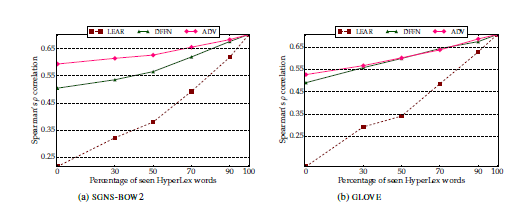

</center>


- LexSub: Like other previous models, the inputs in LexSub are non-contextual embeddings (Glove embeddings) and by means of a loss function that takes into account hyponyms, antonymns, synomys, the embeddings are retrained. The authors train LEAR and LexSub with: firstly, less lexical resources than in LEAR's paper; secondly, with the same resources. The latter reported Spearman correlation for LEAR should similar than the correlation reported in LEAR's paper, but it doesn't match at all : $0.533$ vs. $0.686$ (may be due to the initial embeddings?). They report the following results:

<center>

|     | less resorc. | more resor |
|----|----|----|
|LEAR|0.1384 | 0.5024|
|LexSub| 0.2615 | 0.5327|

</center>


- Hierarchical-fitting: Finally, HF trains again non-contextual embeddings using lexical pairs from WordNet, but with a novel loss function called by the authors *Hierarchical-fitting*.

####**How baseline results are obtained**
Except for SDNS model, all of the rest models are unsurpervised. But, as we disccuss above, the unsupervised models see the words in the Hyperlex dataset during training in the form of pair constraints. Thus, these models can be compared with our models trained with the datasets under the Hyperlex random configuration, since $100\%$ of the words in train/val datasets are in the test dataset. GLEN and POSTLE papers also perform controlled experiments in such a way that during their training, it is not seen any word of the Hyperlex dataset, and they also do the same for the LEAR model. In this case, these models are compared with our models trained with the lexical configuration of Hyperlex. Thus, we get the comparable results with the random split from the regarding papers of all models, and the comparable results with the lexical split from GLEN, POSTLE and SDNS papers.

####**Our proposal**
An elemental form to give a LE grade is to use the probability $p_{hyp}$ for the the `hyp` label calculated by one of our masked/non-masked models: Greater/lower $p_{hyp}$, more/less sure we are that the pair represent an hyponym. But, let's say that one pair gets the probabilities $p_{hyp}=0.8$ and $p_{syn}=0.15$, an another pair obtains $p_{hyp}=0.8$ and $p_{syn}=0.05$. If we have two pairs with similar probabilities to be an hyponym, but one of them with higher probability to be a synonym, as in the above example, this could be an indication that the first pair should be given a higher *hyponym* degree. We can argue the same, but in the reverse sense, with other labels such as $p_{mero}$ or $p_{norel}$. Thus, if the calculated probabilities really represented the certainty about the lexical relations of two words, we could find a linear combination of the probabilities to obtain a grade for LE, that is, we could give some weights $\beta_{hyp}, \beta_{syn},\beta_{norel}, \dots$, such that knowing the probabilities of a pair $p_{hyp}, p_{syn},p_{norel}, \dots$, we would get the hyperonym degree as the value,

 $$grade = \beta_{hyp}p_{hyp}+\beta_{syn}p_{syn}+\beta_{norel}p_{norel} + \dots$$
Similarly, we can also use the logits instead of the probabilities to find the weights $\beta_i$.

One simple way to obtain the weights is to use the validation set to fit a linear regression model where the response variable is the `grade` given by the human annotators and the predictors are the logtis produce by the fine-tuned model (we also tried to use the probabilities insted of logits, and the results were quite similar). The estimated regresion coefficients will be our weights.

Our method follows:
1. We collapse all `hyp-i` and `r-hpy-i` labels to `hyp` and `r-hyp`, respectively. Thus, we train the model/template with $7$ classes: `ant`, `syn`, `hyp`, `r-hyp`, `cohyp`, `mero` and `no_rel`. In early testing, it seemed that having too many labels and too little data was hurting performance.
2. A model/template is trained with the train/val datasets as it is described in the paper. It is run $10$ epochs and the final model is the best one on the val dataset regarding the metrics: For non-masked trained models, the metric is the macro average; and for masked models, it is the cross-entropy loss for the masked tokens.
3. Post-processing: Once the model/template is trained, it is calculated the predicted logit of the labels for each pair in the val dataset. Thus, we get a matrix $A = [l_i^j]$, where $l_i^j$ is the logit of the $j$-th label for the $i$-th pair in the val dataset. A linear regression model is fitted to predict the vector of the median human ratings $\boldsymbol{r}_{val}=(r_1,\dots,r_n)$. So, we obtain a vector of $7$ weights, $\boldsymbol{\beta} = (\beta_1, \dots, \beta_7)$, such that,
$$\boldsymbol{r}_{val}\approx \boldsymbol{\beta} \cdot M$$
4. The vector $\boldsymbol{\beta}$ is used to predict our rating: Given a pair in the test dataset, it is calculated its vector of logits  $\boldsymbol{l}=(l_1,\dots, l_7)$ for the labels; our final rating is $\boldsymbol{\beta} \cdot \boldsymbol{l}$.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import glob
import ast
import re
import copy
import math
from scipy import stats
from scipy.stats import spearmanr
import seaborn as sns


In [ ]:
# folder with all datasets
DIR_DATASETS = '/content/datasets/'
# folder with the results
DIR_RESULTS = '/content/results/'
LIST_DIR_RES = [DIR_RESULTS + 'K_H+N/',
                DIR_RESULTS + 'BLESS/',
                DIR_RESULTS + 'EVALution/',
                DIR_RESULTS + 'ROOT09/',
                DIR_RESULTS + 'CogALexV/',
                DIR_RESULTS + 'hyperlex/results_hyperlex_lexical_split/',
                DIR_RESULTS + 'hyperlex/results_hyperlex_random_split/'
                ]


In [ ]:
models2abrev = {'bert-large-uncased-whole-word-masking'.lower():'Bert',
				   'roberta-large'.lower():'Roberta',
                   'roberta-base'.lower(): 'roberta-base',
                   'bert-base-uncased'.lower(): "bert-base"
				  }
templates2abrev = {"' <W1> ' <SEP> ' <W2> '".lower(): 'T1',
                  " <W1> <SEP> <W2> ".lower(): 'T2',
                  "Today, I finally discovered the relation between <W1> and <W2>.".lower() : 'T3',
                  "Today, I finally discovered the relation between <W1> and <W2>: <W1> is the <LABEL> of <W2>.".lower() : 'T4',
                  "' <W1> ' <MASK> ' <W2> '".lower(): 'TM1',
                  " <W1> <MASK> <W2> ".lower(): 'TM2',
                  "Today, I finally discovered the relation between <W1> and <W2>: <W1> is the <MASK> of <W2>.".lower() : 'TM3',
                  }
reverse_models2abrev = {v:k for k, v in models2abrev.items()}
reverse_templates2abrev = {v:k for k, v in templates2abrev.items()}

##**Read txt and csv result files and save results in `dict_res`**
`dict_res` is a dictionary of dictionaries with the following structure:
- `dict_res[dataset]`: dictionary with all results for a dataset. One from:
 ```
 ['bless', 'k&h+n','cogalexv','evalution','root09']
 ```
-`dict_res[dataset][model]`: dictionary with all results for a dataset and model
-`dict_res[dataset][model][template]`: dictionary with all results for a dataset, model and template
-`dict_res[dataset][model][template]['res']`: list of dataframes from csv files. It should contain $5$ dataframes
-`dict_res[dataset][model][template]['report']`:  list of classification reports in txt files. It should contain $5$ reports. The reports are the output dictionaries of the function `classification_report` in the `sklearn.metrics` package, adding:
  1. For CogALexV dataset, the weighted f1-score taking into account all labels except the `random` label, if such label exists. Otherwise, the  weighted f1-score is set to $-1$;
  2. For Hyperlex dataset, the Spearman correlations with the median of the human annotators and the following calculated scores: the logit of one label; the learned combination of all label logits; the learned combination of all label probs; it is also added these correlations rstricted to nouns and verbs.
-`dict_res[dataset][model][template]['mean_report']`: classification report with the means and stds of the $5$ classification reports.

Classification reports ( the outputs of `classification_report` function) are also dictionaries of dictionaries:

 ```
 { 'label1': {'precison':xxx, 'recall':yyy, 'f1-score':zzz, 'correlation':ccc (correlation only for hyperlex dataset)}
   ....
   'labeln': {'precison':xxx, 'recall':yyy, 'f1-score':zzz}
   'accuracy': xxx,
   'macro avg': {'precison':xxx, 'recall':yyy, 'f1-score':zzz}
   'weighted avg': {'precison':xxx, 'recall':yyy, 'f1-score':zzz}
   'weigthed f1-score not random':xxxxx},
   //only for hyperlex dataset
   'spearman_logit': {'correlation':cccc, 'pvalue':pppp},
   'spearman_prob': {'correlation':cccc, 'pvalue':pppp},
   'spearman_nouns_logit': {'correlation':cccc, 'pvalue':pppp},
   'spearman_nouns_prob': {'correlation':cccc, 'pvalue':pppp},
   'spearman_verbs_logit': {'correlation':cccc, 'pvalue':pppp},
   'spearman_verbs_prob': {'correlation':cccc, 'pvalue':pppp},
   'coefs_logit':{'l0':lll,...        ,'l7':lll, 'intercept':iii},
   'coefs_prob':{'l0':lll,...,'l6':lll, 'intercept':iii},
```
The `dict_res[dataset][model][template]['mean_report']` classification report is created using the $5$ classification reports of one experiment for a dataset/model/template. It contains the same structure that the above classification report adding the std for precision, recall, f1-score values and the accuracy:
 ```
{ 'label1': {'precison':meanxxx, 'recall':meanyyy, 'f1-score':meanzzz, 'correlation':meancccc, (correlation only for hyperlex dataset)
             'std_precison':ssx, 'std_recall':ssy, 'std_f1-score':ssz, 'std_correlation':ssc}
   ....
   'labeln': {'precison':meanxxx, 'recall':meanyyy, 'f1-score':meanzzz,'correlation':meancccc,
              'std_precison':ssx, 'std_recall':ssy, 'std_f1-score':ssz, 'std_correlation':ssc}
   'accuracy': meanxxx,
   'std_accuracy':sss
   'macro avg': {'precison':meanxxx, 'recall':meanyyy, 'f1-score':meanzzz,
                 'std_precison':ssx, 'std_recall':ssy, 'std_f1-score':ssz}
   'weighted avg': {'precison':meanxxx, 'recall':meanyyy, 'f1-score':meanzzz,
                    'std_precison':ssx, 'std_recall':ssy, 'std_f1-score':ssz},
   'weigthed f1-score not random':meanxxx,
   'std_weigthed f1-score not random':ssxxx,}
   //only for hyperlex dataset
   'spearman_logit': {'correlation':meancc, 'pvalue':meanpp,'std_correlation':sscc, 'std_pvalue':sspp},
   'spearman_prob': {'correlation':meancc, 'pvalue':meanpp,'std_correlation':sscc, 'std_pvalue':sspp},
   'spearman_nouns_logit': {'correlation':meancc, 'pvalue':meanpp,'std_correlation':sscc, 'std_pvalue':sspp},
   'spearman_verbs_logit': {'correlation':meancc, 'pvalue':meanpp,'std_correlation':sscc, 'std_pvalue':sspp},
   'spearman_nouns_prob': {'correlation':meancc, 'pvalue':meanpp,'std_correlation':sscc, 'std_pvalue':sspp},
   'spearman_verbs_prob': {'correlation':meancc, 'pvalue':meanpp,'std_correlation':sscc, 'std_pvalue':sspp},
   'coefs_logit':{'l0':meanl,...        ,'l7':meanl, 'intercept':meani,
                 'std_l0':meanl,...      ,'std_l7':meanl, 'std_intercept':meani},
   'coefs_prob':{'l0':meanl,...   ,'l6':meanl, 'intercept':meani,
                 'std_l0':meanl,... ,'std_l6':meanl, 'std_intercept':meani}
```

**Read txt and csv result files from our scripts**.

They are read from a list of folders in variable `LIST_DIR_RES`

In [ ]:
def calculate_weighted_f1_no_random(dict_report):
    '''
    Function to calculate the weigthed f1-score by support of all labels
    except the random label, if the random label exists. If it not exists
    return -1
    '''
    except_list = ['accuracy', 'macro avg', 'weighted avg', 'std_accuracy', 'random']
    weighted_f1_no_random = -1
    if 'random' in dict_report.keys():
        total_support_no_random = 0
        for k in dict_report:
            if k.lower() not in except_list:
                weighted_f1_no_random += dict_report[k]['support']*dict_report[k]['f1-score']
                total_support_no_random += dict_report[k]['support']
        weighted_f1_no_random = weighted_f1_no_random/total_support_no_random

    return weighted_f1_no_random

In [ ]:
def from_spearman_string_to_dict(spearman_string):
    spearman_string = re.sub("SpearmanrResult", "", spearman_string)
    spearman_string = re.sub("correlation=","'correlation':",spearman_string)
    spearman_string = re.sub("pvalue=","'pvalue':",spearman_string)
    spearman_string = re.sub("\(", "{", spearman_string)
    spearman_string = re.sub("\)", "}", spearman_string)
    spearman = ast.literal_eval(spearman_string)
    return spearman

dict_res = {}
LABEL_WEIGHTED_NOT_RANDOM = 'weighted f1-score not random'

for dir in LIST_DIR_RES:
    list_txt_files = glob.glob(dir + "*.txt")
    list_csv_files = [re.sub("txt$", "csv", f) for f in list_txt_files]
    for txt_file, csv_file in zip(list_txt_files, list_csv_files):
        # read and process txt results file
        with open(txt_file) as ftxt:
            # line 1: arguments
            #print(txt_file)
            par = ast.literal_eval(ftxt.readline())
            if par['dataset'].lower() == 'hyperlex':
                if 'hyperlex/random' in par['train_file']:
                    par['dataset'] = 'hyperlex-random'
                else:
                    par['dataset'] = 'hyperlex-lexical'
            # line 2: date
            ftxt.readline()
            # line 3: report
            report = ast.literal_eval(ftxt.readline().lower())
            # line 4: hyperlex correlation by label
            spearman_string = ftxt.readline()
            if spearman_string != '':
                spearman = from_spearman_string_to_dict(spearman_string)
                # add spearman correlations to report
                for label in list(spearman.keys()):
                    report[label]['correlation'] = spearman[label]['correlation']
            # line 5: overall hyperlex correlation logits
            all_spearman_logit_string = ftxt.readline()
            # line 6: checkpoint overall hyperlex correlation logits
            all_spearman_check_string = ftxt.readline()
            # line 7: overall hyperlex correlation probs
            all_spearman_prob_string = ftxt.readline()
            if all_spearman_logit_string != '':
                all_spearman_logit = from_spearman_string_to_dict(all_spearman_logit_string)
                all_spearman_check = from_spearman_string_to_dict(all_spearman_check_string)
                if (all_spearman_logit['correlation'] != all_spearman_check['correlation']):
                    raise Exception('Error checkpoint: Different Spearman correlations in ' + txt_file)
                all_spearman_prob = from_spearman_string_to_dict(all_spearman_prob_string)
                report['spearman_logit'] = all_spearman_logit
                report['spearman_prob'] = all_spearman_prob
            # line 8: hyperlex logit coefs
            coefs_logit_string = ftxt.readline()
            # line 9: hyperlex probs coefs
            coefs_prob_string = ftxt.readline()
            if coefs_logit_string != '':
                coefs_logit = ast.literal_eval(coefs_logit_string)
                report['coefs_logit'] = {'l'+str(i):c for i,c in enumerate(coefs_logit['coefs'])}
                report['coefs_logit']['intercept'] = coefs_logit['intercept']
                coefs_prob = ast.literal_eval(coefs_prob_string)
                report['coefs_prob'] = {'l'+str(i):c for i,c in enumerate(coefs_prob['coefs'])}
                report['coefs_prob']['intercept'] = coefs_prob['intercept']

        # read csv results file
        res_csv = pd.read_csv(csv_file, quotechar='"',keep_default_na=False)
        # save csv and txt files to dict_res
        a = dict_res.setdefault(par['dataset'].lower(), {})
        b = a.setdefault(par['model'].lower(), {})
        if "RandomMask" in dir:
            par['train_templates'][0] = re.sub("<mask>", "<maskr>", par['train_templates'][0].lower())
        c = b.setdefault(par['train_templates'][0].lower(), {})
        d1 = c.setdefault('res',[])
        d2 = c.setdefault('report',[])
        d1.append(res_csv)
        report[LABEL_WEIGHTED_NOT_RANDOM] = calculate_weighted_f1_no_random(report)
        if 'spearman_logit' in list(report.keys()):
            #distinguir non-masked/masked
            col_names = [nc for nc in res_csv.columns]
            logit_col_names = filter(lambda x: re.match('.*logit$',x), col_names)
            prob_col_names = [re.sub("_logit$", "", c) for c in logit_col_names]
            X_logit = res_csv.filter(regex=('.*logit$')).to_numpy(copy=True)
            X_prob = res_csv[prob_col_names].to_numpy(copy=True)
            X_prob = np.delete(X_prob, 5, axis=1)
            coefs_l = np.array(coefs_logit['coefs'])
            coefs_p = np.array(coefs_prob['coefs'])
            grades = res_csv['grade']
            if 'hyperlex/random' in par['test_file']:
                test_data = pd.read_csv(DIR_DATASETS + 'hyperlex/random/test.tsv',
                                        sep = '\t', header=None)
            else:
                test_data = pd.read_csv(DIR_DATASETS + 'hyperlex/lexical/test.tsv',
                                        sep = '\t', header=None)

            check_spearman_logit = spearmanr(np.dot(X_logit,coefs_l), grades)
            check_spearman_prob =  spearmanr(np.dot(X_prob,coefs_p), grades)
            # checkpoint: It must be equal (upto thousandths) the Spearman correlations
            # calculated in the experiments and the ones calculated in this test
            if abs(check_spearman_logit[0] - report['spearman_logit']['correlation']) > 0.001:
                raise Exception('Check: Different logit prob from experiments and test: ' + str(check_spearman_logit[0]) + '  ' + str(report['spearman_logit']['correlation']) )
            if abs(check_spearman_prob[0] - report['spearman_prob']['correlation']) > 0.001:
                raise Exception('Check: Different spearman prob from experiments and test: ' + str(check_spearman_prob[0]) + '  ' + str(report['spearman_prob']['correlation']) )

            nouns_idx = test_data.iloc[:,2] == 'N'
            verbs_idx = test_data.iloc[:,2] == 'V'
            spearman_nouns_logit = spearmanr(np.dot(X_logit[nouns_idx,:],coefs_l), grades[nouns_idx])
            spearman_verbs_logit = spearmanr(np.dot(X_logit[verbs_idx,:],coefs_l), grades[verbs_idx])
            spearman_nouns_prob = spearmanr(np.dot(X_prob[nouns_idx,:],coefs_p), grades[nouns_idx])
            spearman_verbs_prob = spearmanr(np.dot(X_prob[verbs_idx,:],coefs_p), grades[verbs_idx])
            report['spearman_nouns_logit'] = from_spearman_string_to_dict(str(spearman_nouns_logit))
            report['spearman_verbs_logit'] = from_spearman_string_to_dict(str(spearman_verbs_logit))
            report['spearman_nouns_prob'] = from_spearman_string_to_dict(str(spearman_nouns_prob))
            report['spearman_verbs_prob'] = from_spearman_string_to_dict(str(spearman_verbs_prob))
        d2.append(report)

**Add the mean report**.



In [ ]:
def get_value(one_report, keys):
    val = one_report
    for k in keys:
        val = val[k]
    return val

def get_values(list_reports, keys):
    values = np.array([get_value(one_report, keys) for one_report in list_reports])
    return values

def calculateMeansRec(list_reports, one_dict, past_keys, exclude_keys):
    for k in list(one_dict.keys()):
        if k not in exclude_keys:
            copy_past_keys = copy.deepcopy(past_keys)
            copy_past_keys.append(k)
            if not isinstance(one_dict[k], dict):
                values = get_values(list_reports, copy_past_keys)
                one_dict[k]= values.mean()
                one_dict['std_'+k] = values.std()
            else:
                calculateMeansRec(list_reports, one_dict[k], copy_past_keys, exclude_keys)

def flat_list_reportsRec(list_reports, one_dict, past_keys, exclude_keys):
    for k in list(one_dict.keys()):
        if k not in exclude_keys:
            copy_past_keys = copy.deepcopy(past_keys)
            copy_past_keys.append(k)
            if not isinstance(one_dict[k], dict):
                values = get_values(list_reports, copy_past_keys)
                one_dict[k]= values.tolist()
            else:
                flat_list_reportsRec(list_reports, one_dict[k], copy_past_keys, exclude_keys)

def calculateMeans(list_reports):
    '''
    Given a list of structurally equal reports, the function
    returns a report with the means and stds. A report is a dictionary
    whose values are either a dictionary or a real number.
    '''
    means_report = copy.deepcopy(list_reports[0])
    calculateMeansRec(list_reports, means_report, past_keys=[], exclude_keys=['support'])

    return means_report

def flat_list_reports(list_reports):
    '''
    Given a list of structurally equal reports, the function returns
    a structurally equal report join in a list all values that are real numbers.
    A report is a dictionary whose values are either a dictionary or a real number.
    '''
    flat_report = copy.deepcopy(list_reports[0])
    flat_list_reportsRec(list_reports, flat_report, past_keys=[], exclude_keys=['support'])

    return flat_report

In [ ]:
for d in dict_res:
    print(d.upper())
    for m in dict_res[d]:
        print(" -".join(['Calculating:', d, m]))
        for t in dict_res[d][m]:
            list_reports = dict_res[d][m][t]['report']
            print(" -".join(["    ", t, templates2abrev[t] ]))
            dict_res[d][m][t]['mean_report'] = calculateMeans(list_reports)
            dict_res[d][m][t]['flat_reports'] = flat_list_reports(list_reports)

K&H+N
Calculating: -k&h+n -bert-base-uncased
     -today, i finally discovered the relation between <w1> and <w2>: <w1> is the <mask> of <w2>. -TM3
     - <w1> <sep> <w2>  -T2
     - <w1> <mask> <w2>  -TM2
     -today, i finally discovered the relation between <w1> and <w2>: <w1> is the <label> of <w2>. -T4
     -' <w1> ' <sep> ' <w2> ' -T1
     -today, i finally discovered the relation between <w1> and <w2>. -T3
     -' <w1> ' <mask> ' <w2> ' -TM1
Calculating: -k&h+n -bert-large-uncased-whole-word-masking
     -today, i finally discovered the relation between <w1> and <w2>. -T3
     - <w1> <sep> <w2>  -T2
     - <w1> <mask> <w2>  -TM2
     -today, i finally discovered the relation between <w1> and <w2>: <w1> is the <mask> of <w2>. -TM3
     -' <w1> ' <mask> ' <w2> ' -TM1
     -' <w1> ' <sep> ' <w2> ' -T1
     -today, i finally discovered the relation between <w1> and <w2>: <w1> is the <label> of <w2>. -T4
Calculating: -k&h+n -roberta-base
     -today, i finally discovered the relation

##**Dictionary with best results**
Given the dictionary of results `dict_res`, the following functions create `dict_best`, a python dictionary of dictionaries with the best results for any measure and model/template. It has the structure:
 - `dict_best[dataset]`: It is a dictionary with the best results for a dataset. One from:
 ```
 ['bless', 'k&h+n','cogalexv','evalution','root09']
 ```
 - `dict_best[dataset]`: It is a dictionary with the best results for a dataset:


 ```
 {label1: { 'precision': {'best_val': xxxx,
                          'best_model':mmmm,
                          'best_template':tttt,
                          'p-vals': {model: { template_1: pppp,
                                              ....
                                              template_k:pppp}}},
              'recall': {'best_val': xxxx,
                         'best_model':mmmm,
                         'best_template':tttt,
                         'p-vals': {model: { template_1: pppp,
                                             ....
                                             template_k:pppp}}},
              'f1-score': {'best_val': xxxx,
                           'best_model':mmmm,
                           'best_template':tttt,
                           'p-vals': {model: { template_1: pppp,
                                                ....
                                                template_k:pppp}}},
           //only for hyperlex dataset
           'correlation': {'best_val': xxxx,
                           'best_model':mmmm,
                           'best_template':tttt,
                           'p-vals': {model: { template_1: pppp,
                                                ....
                                                template_k:pppp}}}}}                                                
  ....
  labeln: {same label 1 ...}
  'accuracy': {'best_val': xxxx,
               'best_model':mmmm,
               'best_template':tttt,
               'p-vals': {model: { template_1: pppp,
                                    ....
                                    template_k:pppp}}},
  'macro avg':{similar to label 1...},
  'weighted avg' :{similar to label 1...},
  'weigthed f1-score not random': {similar to accuracy...},
   //only for hyperlex dataset
   'spearman_logit': {...},
   'spearman_prob': {...},
   'spearman_nouns_logit': {...},
   'spearman_verbs_logit': {...},
   'spearman_nouns_prob': {...},
   'spearman_verbs_prob': {...},
   'coefs_logit':{...},
   'coefs_prob':{...}
 }
```                                      


For example,
- `dict_best['k&h+n']['ant']['precision']['best_val']` contains the best **mean** precision value among all models and templates for the antonyms label,
- `dict_best['k&h+n']['ant']['precision']['best_model']` is the model for which the best precision has been obtained,
- and  `dict_best['k&h+n']['ant']['precision']['best_template']` is the template for which the best precision has been obtained.

The `dict_best` dictionary also contains the p-values comparing the mean of the best model/template with any other mean for a model/template. It is used a Welch's test to check if there is statistical evidence that the means are different. So, for instance the value in
```
dict_best['k&h+n']['ant']['precision']['p-vals']['roberta-large'][' <w1> <sep> <w2> ']
```
contains the p-value to check if the mean of the $5$ precision values of our experiments for antonyms in K&H+N dataset trained with the RoBERTa large model and the template ` <W1> <SEP> <W2> ` is different from the mean of the $5$ precision values obtained with the model/template that has got the best mean precision value.

In [ ]:
def create_empty(one_dict, empty_best_dict, suffix=''):
    for label in one_dict:
        empty_best_dict[label+suffix]={}
        if isinstance(one_dict[label], dict):
            for sublabel in one_dict[label]:
                if sublabel != 'support':
                    empty_best_dict[label+suffix][sublabel] = {}
                    empty_best_dict[label+suffix][sublabel]['best_val'] = -1.0
                    empty_best_dict[label+suffix][sublabel]['best_model'] = ''
                    empty_best_dict[label+suffix][sublabel]['best_template'] = ''
        else:
            empty_best_dict[label+suffix]['best_val'] = -1.0
            empty_best_dict[label+suffix]['best_model'] = ''
            empty_best_dict[label+suffix]['best_template'] = ''

def create_empty_best_dict(dict_res, dataset):
    m0 = list(dict_res[dataset].keys())[0]
    t0 = list(dict_res[dataset][m0].keys())[0]
    empty_best_dict = {}
    one_dict = dict_res[dataset][m0][t0]['report'][0]
    create_empty(one_dict, empty_best_dict)
    return empty_best_dict

def create (dict_mean_rep, m, t, best_dict_dataset):
    for label in dict_mean_rep:
        if label in list(best_dict_dataset.keys()):
            if isinstance(dict_mean_rep[label], dict):
                for sublabel in dict_mean_rep[label]:
                    if sublabel in list(best_dict_dataset[label].keys()):
                        if dict_mean_rep[label][sublabel] > best_dict_dataset[label][sublabel]['best_val']:
                            best_dict_dataset[label][sublabel]['best_val'] = dict_mean_rep[label][sublabel]
                            best_dict_dataset[label][sublabel]['best_model'] = m
                            best_dict_dataset[label][sublabel]['best_template'] = t
            else:
                if dict_mean_rep[label] >= best_dict_dataset[label]['best_val']:
                    best_dict_dataset[label]['best_val'] = dict_mean_rep[label]
                    best_dict_dataset[label]['best_model'] = m
                    best_dict_dataset[label]['best_template'] = t

def create_best_dict_dataset(dict_res, d):
    '''
    For a dataset d, create the best dictionary without p-values
    '''
    best_dict_dataset = create_empty_best_dict(dict_res, d)
    for m in dict_res[d]:
        for t in dict_res[d][m]:
            create(dict_res[d][m][t]['mean_report'], m, t, best_dict_dataset)
    return best_dict_dataset

def create_pvals_dataset(best_dict, dict_res, dataset, label, sublabel=None):
    '''
    Given a best_dict without p-values and dictionary of results, label and sublabel
    create a dictionary containing the p-values for label and sublabel.
    '''
    dict_pvals = {}
    if sublabel is not None:
        mref = best_dict[dataset][label][sublabel]['best_model']
        tref = best_dict[dataset][label][sublabel]['best_template']
        list_reports = dict_res[dataset][mref][tref]['report']
        list_ref_max = [rep[label][sublabel] for rep in list_reports]
    else:
        mref = best_dict[dataset][label]['best_model']
        tref = best_dict[dataset][label]['best_template']
        list_reports = dict_res[dataset][mref][tref]['report']
        list_ref_max = [rep[label] for rep in list_reports]

    for m in dict_res[dataset]:
        for t in dict_res[dataset][m]:
            if not (m == mref and t == tref):
                if sublabel is not None:
                    list_reports_others = dict_res[dataset][m][t]['report']
                    list_vals = [rep[label][sublabel] for rep in list_reports_others]
                else:
                    list_reports_others = dict_res[dataset][m][t]['report']
                    list_vals = [rep[label] for rep in list_reports_others]

                pval = stats.ttest_ind(list_ref_max, list_vals, equal_var=False)[1]
                dict_1 = dict_pvals.setdefault(m,{})
                dict_1[t] = pval
    return dict_pvals


In [ ]:
def create_dict_best(dict_res):
    '''
    Given a dictionary of results, it returns a dictionary of best results
    '''
    # create best dictionary without p-vals
    dict_best_1={}
    for d in dict_res:
        dict_best_1[d] = create_best_dict_dataset(dict_res, d)

    # create best dictionary adding p-vals
    dict_best = copy.deepcopy(dict_best_1)
    for d in dict_best_1:
        for label in dict_best_1[d]:
            if 'best_val' in list(dict_best_1[d][label]):
                dict_best[d][label]['p-vals'] = create_pvals_dataset(dict_best_1, dict_res, d, label)
            else:
                for sublabel in dict_best_1[d][label]:
                    dict_best[d][label][sublabel]['p-vals'] = create_pvals_dataset(dict_best_1, dict_res, d, label,sublabel)
    return dict_best

dict_best = create_dict_best(dict_res)

##**CogALexV**
To process the CogALexV results. Note that the results for templates `T1`-`T4` correspond to the non-masked models, and templates `TM1`-`TM3`for the masked ones. See the dictionary `templates2abrev` in a cell above.

In [ ]:
def get_dataframe_results_cogalexv(dict_res, dataset):
    except_list = ['accuracy', 'macro avg', 'weighted avg', 'std_accuracy', 'std_'+LABEL_WEIGHTED_NOT_RANDOM, 'random']
    dict_df = {'dataset': [], 'model':[], 'template':[]}
    col_tuples=[]
    create_tuples = True
    for m in dict_res[dataset.lower()]:
        for t in dict_res[dataset.lower()][m]:
            mean_report = dict_res[dataset.lower()][m][t]['mean_report']
            dict_df['dataset'].append(dataset)
            dict_df['model'].append(m)
            dict_df['template'].append(t)
            for k in mean_report:
                if k not in except_list:
                    l = dict_df.setdefault(k, [])
                    if k != LABEL_WEIGHTED_NOT_RANDOM:
                        l.append(mean_report[k]['f1-score'])
                        if create_tuples:
                            col_tuples.append((k,'f1-score'))
                    else:
                        l.append(mean_report[k])
            create_tuples = False
    res_df = pd.DataFrame.from_dict(dict_df)
    res_df['model'] = res_df['model'].apply(lambda x : models2abrev[x])
    res_df['template'] = res_df['template'].apply(lambda x : templates2abrev[x])
    multi_row = pd.MultiIndex.from_frame(res_df.iloc[:,1:3],sortorder=None)
    col_tuples.append(('all','weighted f1-score'))
    col_index = pd.MultiIndex.from_tuples(col_tuples)
    res_df = res_df.iloc[:, 3:].copy()
    res_df.index = multi_row
    res_df.columns = col_index
    return res_df

def get_dataframe_results_max_min_cogalexv(dict_res, dataset):
    except_list = ['accuracy', 'macro avg', 'weighted avg', 'std_accuracy', 'std_'+LABEL_WEIGHTED_NOT_RANDOM, 'random']
    dict_df = {'dataset': [], 'model':[], 'template':[]}
    col_tuples=[]
    create_tuples_labels = True
    create_tuples_all = True
    for m in dict_res[dataset.lower()]:
        for t in dict_res[dataset.lower()][m]:
            flat_reports = dict_res[dataset.lower()][m][t]['flat_reports']
            dict_df['dataset'].append(dataset)
            dict_df['model'].append(m)
            dict_df['template'].append(t)
            for k in flat_reports:
                if k not in except_list:
                    l_max = dict_df.setdefault('max-'+ k, [])
                    l_min = dict_df.setdefault('min-'+ k, [])
                    l_std = dict_df.setdefault('std-'+ k, [])
                    if k != LABEL_WEIGHTED_NOT_RANDOM:
                        l_max.append(np.array(flat_reports[k]['f1-score']).max())
                        l_min.append(np.array(flat_reports[k]['f1-score']).min())
                        l_std.append(np.array(flat_reports[k]['f1-score']).std())
                        if create_tuples_labels:
                            col_tuples.append((k,'max-f1-score'))
                            col_tuples.append((k,'min-f1-score'))
                            col_tuples.append((k,'std-f1-score'))
                    else:
                        l_max.append(np.array(flat_reports[k]).max())
                        l_min.append(np.array(flat_reports[k]).min())
                        l_std.append(np.array(flat_reports[k]).std())
                        if create_tuples_all:
                            col_tuples.append((k,'max-all'))
                            col_tuples.append((k,'min-all'))
                            col_tuples.append((k,'std-all'))
            create_tuples_labels = False
            create_tuples_all = False
    res_df = pd.DataFrame.from_dict(dict_df)
    res_df['model'] = res_df['model'].apply(lambda x : models2abrev[x])
    res_df['template'] = res_df['template'].apply(lambda x : templates2abrev[x])
    multi_row = pd.MultiIndex.from_frame(res_df.iloc[:,1:3],sortorder=None)
    #col_tuples.append(('all','weighted f1-score'))
    col_index = pd.MultiIndex.from_tuples(col_tuples)
    res_df = res_df.iloc[:, 3:].copy()
    res_df.index = multi_row
    res_df.columns = col_index
    return res_df

In [ ]:
df_cogalexv_final = get_dataframe_results_cogalexv(dict_res, 'CogALexV')
df_cogalexv_final = df_cogalexv_final.sort_index(level=['model','template'])

In [ ]:
FILE_SOTAS_COGALEXV = DIR_RESULTS + 'sotas_results_literature/cogalexv_Sotas_RC.txt'
df_sotas_cogalexv = pd.read_csv(FILE_SOTAS_COGALEXV, header=[0,1], index_col=[0], skipinitialspace=True)
multi_row_tuples = list(zip(['Sota']*df_sotas_cogalexv.shape[0], list(df_sotas_cogalexv.index)))
multi_row = pd.MultiIndex.from_tuples(multi_row_tuples)
df_sotas_cogalexv.index=multi_row
df_res_sotas_cogalexv = pd.concat([df_cogalexv_final,df_sotas_cogalexv])

#change column order
order1 = {'ant':0,'hyper':1,'part_of':2, 'syn':3, 'all':4}
multi_col_list = list(df_res_sotas_cogalexv.columns)
multi_col_list.sort(key=lambda x: order1[x[0].lower()])
multi_col = pd.MultiIndex.from_tuples(multi_col_list)
df_res_sotas_cogalexv = pd.DataFrame(df_res_sotas_cogalexv, columns=multi_col)
df_res_sotas_cogalexv

ant     hyper   part_of       syn  \
                       f1-score  f1-score  f1-score  f1-score   
model        template                                           
Bert         T1        0.770474  0.680452  0.715095  0.563975   
             T2        0.768676  0.675201  0.727876  0.528010   
             T3        0.788689  0.681299  0.735502  0.565756   
             T4        0.119323  0.044062  0.077908  0.000000   
             TM1       0.798389  0.682221  0.745577  0.584719   
             TM2       0.781551  0.687806  0.742477  0.560105   
             TM3       0.778578  0.682159  0.742217  0.562916   
Roberta      T1        0.872557  0.703143  0.752050  0.603664   
             T2        0.863005  0.681854  0.744814  0.583635   
             T3        0.883666  0.718214  0.784419  0.628822   
             T4        0.236519  0.003704  0.164753  0.084852   
             TM1       0.879658  0.708541  0.772999  0.598834   
             TM2       0.870704  0.723055  0.787251  0.621032   
             TM3       0.870720  0.717585  0.787410  0.615927   
bert-base    T1        0.553600  0.590749  0.657085  0.361485   
             T2        0.528956  0.544102  0.610356  0.277698   
             T3        0.565381  0.605407  0.683618  0.374989   
             T4        0.081221  0.000000  0.101444  0.006059   
             TM1       0.644556  0.625010  0.707385  0.431301   
             TM2       0.570093  0.621784  0.685384  0.393129   
             TM3       0.635968  0.648195  0.720730  0.430058   
roberta-base T1        0.805550  0.677129  0.732487  0.569636   
             T2        0.782981  0.651829  0.692575  0.536492   
             T3        0.819614  0.675679  0.731475  0.576918   
             T4        0.026575  0.000000  0.102297  0.092189   
             TM1       0.809081  0.678229  0.743181  0.560552   
             TM2       0.801448  0.673224  0.742456  0.555826   
             TM3       0.814963  0.679439  0.729843  0.560999   
Sota         LexNET    0.425000  0.526000  0.493000  0.297000   
             SphereRE  0.479000  0.538000  0.539000  0.286000   
             KEML      0.492000  0.547000  0.652000  0.292000   
             RelBert   0.794000  0.616000  0.702000  0.505000   

                                    all  
                      weighted f1-score  
model        template                    
Bert         T1                0.690274  
             T2                0.683411  
             T3                0.700158  
             T4                0.063480  
             TM1               0.708948  
             TM2               0.700283  
             TM3               0.698097  
Roberta      T1                0.742749  
             T2                0.727845  
             T3                0.761832  
             T4                0.118573  
             TM1               0.749557  
             TM2               0.758490  
             TM3               0.755786  
bert-base    T1                0.546293  
             T2                0.498959  
             T3                0.562078  
             T4                0.043619  
             TM1               0.607497  
             TM2               0.572578  
             TM3               0.614543  
roberta-base T1                0.704082  
             T2                0.675341  
             T3                0.709073  
             T4                0.044251  
             TM1               0.705707  
             TM2               0.700768  
             TM3               0.705455  
Sota         LexNET            0.445000  
             SphereRE          0.471000  
             KEML              0.500000  
             RelBert           0.664000

In [ ]:
df_cogalexv_max_min_final = get_dataframe_results_max_min_cogalexv(dict_res, 'CogALexV')
df_cogalexv_max_min_final = df_cogalexv_max_min_final.sort_index(level=['model','template'])
df_cogalexv_max_min_final

ant                                  hyper  \
                      max-f1-score min-f1-score std-f1-score max-f1-score   
model        template                                                       
Bert         T1           0.788540     0.754986     0.011111     0.693042   
             T2           0.784203     0.752044     0.012690     0.697095   
             T3           0.797122     0.776406     0.007539     0.687879   
             T4           0.220661     0.000000     0.099786     0.138219   
             TM1          0.805556     0.789250     0.006764     0.694891   
             TM2          0.797768     0.765537     0.011892     0.696296   
             TM3          0.812589     0.763948     0.017595     0.691771   
Roberta      T1           0.890469     0.836524     0.019903     0.735724   
             T2           0.905109     0.830137     0.024201     0.725067   
             T3           0.896067     0.874644     0.007488     0.734211   
             T4           0.523985     0.000000     0.181011     0.018519   
             TM1          0.888252     0.863572     0.008898     0.714286   
             TM2          0.886657     0.862119     0.008853     0.732432   
             TM3          0.879536     0.861671     0.007292     0.724965   
bert-base    T1           0.563415     0.543478     0.006968     0.598854   
             T2           0.550336     0.508906     0.015003     0.560647   
             T3           0.580132     0.539642     0.015095     0.615385   
             T4           0.189547     0.000000     0.077721     0.000000   
             TM1          0.655172     0.631136     0.008916     0.634538   
             TM2          0.593123     0.550512     0.016477     0.631436   
             TM3          0.653061     0.615836     0.012420     0.656381   
roberta-base T1           0.821683     0.789400     0.011938     0.703601   
             T2           0.802837     0.761134     0.013577     0.673130   
             T3           0.832386     0.810512     0.008108     0.701513   
             T4           0.080925     0.000000     0.033812     0.000000   
             TM1          0.826896     0.792614     0.012819     0.690667   
             TM2          0.813097     0.787535     0.008702     0.686192   
             TM3          0.827586     0.803443     0.009157     0.698727   

                                                     part_of               \
                      min-f1-score std-f1-score max-f1-score min-f1-score   
model        template                                                       
Bert         T1           0.662953     0.011157     0.744292     0.676724   
             T2           0.642336     0.021950     0.749474     0.702820   
             T3           0.675250     0.005329     0.740566     0.729670   
             T4           0.000000     0.056808     0.289157     0.000000   
             TM1          0.670537     0.008846     0.758772     0.726437   
             TM2          0.671576     0.008973     0.748837     0.740088   
             TM3          0.668648     0.007784     0.766520     0.724221   
Roberta      T1           0.662050     0.024285     0.764835     0.730361   
             T2           0.643836     0.030330     0.777778     0.718182   
             T3           0.699454     0.013026     0.798144     0.769231   
             T4           0.000000     0.007407     0.321878     0.100045   
             TM1          0.697274     0.006072     0.789238     0.749415   
             TM2          0.713092     0.007152     0.828054     0.757991   
             TM3          0.709497     0.005322     0.823799     0.771930   
bert-base    T1           0.574386     0.008526     0.684564     0.634573   
             T2           0.522667     0.012943     0.628450     0.586207   
             T3           0.598930     0.005760     0.711111     0.648188   
             T4           0.000000     0.000000     0.138322     0.031250   
             TM1          

##**K&H+N, BLESS, EVALution, ROOT9**
To process the results of these datasets. Note that the results for templates `T1`-`T4` correspond to the non-masked models, and templates `TM1`-`TM3`for the masked ones. See the dictionary `templates2abrev` in a cell above.

In [ ]:
def get_dataframe_results_max_min_measure(dict_res, dataset, measure, list_sub_measures=['precision', 'recall', 'f1-score']):
    inc_index = 3*len(list_sub_measures)
    dict_df = {'dataset': [], 'model':[], 'template':[]}
    for m in dict_res[dataset.lower()]:
        for t in dict_res[dataset.lower()][m]:
            d_measures = dict_res[dataset.lower()][m][t]['flat_reports'][measure]

            dict_df['dataset'].append(dataset)
            dict_df['model'].append(m)
            dict_df['template'].append(t)

            for meas in d_measures:
                if meas in list_sub_measures:
                    l_max = dict_df.setdefault('max-'+meas, [])
                    l_max.append(np.array(d_measures[meas]).max())
                    l_min = dict_df.setdefault('min-'+meas, [])
                    l_min.append(np.array(d_measures[meas]).min())
                    l_std = dict_df.setdefault('std-'+meas, [])
                    l_std.append(np.array(d_measures[meas]).std())

    res_df = pd.DataFrame.from_dict(dict_df)
    res_df['model'] = res_df['model'].apply(lambda x : models2abrev[x])
    res_df['template'] = res_df['template'].apply(lambda x : templates2abrev[x])
    multi_row = pd.MultiIndex.from_frame(res_df.iloc[:,1:3],sortorder=None)
    multi_col = pd.MultiIndex.from_tuples(zip([dataset]*inc_index, res_df.columns[3:(3+inc_index)]),sortorder=None)
    res_df = res_df.iloc[:,3:(3+inc_index)]
    res_df.index = multi_row
    res_df.columns = multi_col
    return res_df

def get_dataframe_results_measure(dict_res, dataset, measure, list_sub_measures=['precision', 'recall', 'f1-score']):
    inc_index = len(list_sub_measures)
    dict_df = {'dataset': [], 'model':[], 'template':[]}
    for m in dict_res[dataset.lower()]:
        for t in dict_res[dataset.lower()][m]:
            d_measures = dict_res[dataset.lower()][m][t]['mean_report'][measure]

            dict_df['dataset'].append(dataset)
            dict_df['model'].append(m)
            dict_df['template'].append(t)

            for meas in d_measures:
                if meas in list_sub_measures:
                    l = dict_df.setdefault(meas, [])
                    l.append(d_measures[meas])

    res_df = pd.DataFrame.from_dict(dict_df)
    res_df['model'] = res_df['model'].apply(lambda x : models2abrev[x])
    res_df['template'] = res_df['template'].apply(lambda x : templates2abrev[x])
    multi_row = pd.MultiIndex.from_frame(res_df.iloc[:,1:3],sortorder=None)
    multi_col = pd.MultiIndex.from_tuples(zip([dataset]*inc_index, res_df.columns[3:(3+inc_index)]),sortorder=None)
    res_df = res_df.iloc[:,3:(3+inc_index)]
    res_df.index = multi_row
    res_df.columns = multi_col
    return res_df

In [ ]:
all_datasets = ['K&H+N', 'BLESS', 'EVALution', 'ROOT09']
list_complete_res = []

for one_dataset in all_datasets:
    if one_dataset.lower() in list(dict_res.keys()):
        df_res = get_dataframe_results_measure(dict_res, one_dataset, 'weighted avg') # one of 'weighted avg' and 'macro avg'
        list_complete_res.append(df_res)
    else:
        print("WARNING: There are not results for dataset " + one_dataset)
df_datasets_final = pd.concat(list_complete_res, axis = 1)

#change column order
order1 = {'k&h+n':0,'bless':1,'evalution':2, 'root09':3}
order2 = {'precision':0,'recall':1,'f1-score':2}
multi_col_list = list(df_datasets_final.columns)
multi_col_list.sort(key=lambda x: 10*order1[x[0].lower()] + order2[x[1].lower()])
multi_col = pd.MultiIndex.from_tuples(multi_col_list)
df_datasets_final = pd.DataFrame(df_datasets_final, columns=multi_col)
df_datasets_final.sort_index(level=['model','template'], inplace=True)

In [ ]:
SOTAS_FILE_REST = DIR_RESULTS + 'sotas_results_literature/khnBlessEvalRoot_Sotas_RC.txt'
sotas_res = pd.read_csv(SOTAS_FILE_REST, header=[0,1], index_col=[0], skipinitialspace=True)
multi_row_tuples = list(zip(['Sota']*sotas_res.shape[0], list(sotas_res.index)))
multi_row = pd.MultiIndex.from_tuples(multi_row_tuples)
sotas_res.index=multi_row
df_res_sotas = pd.concat([df_datasets_final,sotas_res])

#change column order
order1 = {'k&h+n':0,'bless':1,'evalution':2, 'root09':3}
order2 = {'precision':0,'recall':1,'f1-score':2}
multi_col_list = list(df_res_sotas.columns)
multi_col_list.sort(key=lambda x: 10*order1[x[0].lower()] + order2[x[1].lower()])
multi_col = pd.MultiIndex.from_tuples(multi_col_list)

df_res_sotas = pd.DataFrame(df_res_sotas, columns=multi_col)
df_res_sotas.apply(round, ndigits=30)


K&H+N                         BLESS            \
                      precision    recall  f1-score precision    recall   
model        template                                                     
Bert         T1        0.989279  0.989372  0.989283  0.952062  0.950972   
             T2        0.988852  0.988955  0.988862  0.949638  0.948079   
             T3        0.989652  0.989761  0.989652  0.952650  0.951996   
             T4        0.740641  0.587883  0.510361  0.243637  0.200090   
             TM1       0.987078  0.987216  0.987016  0.942206  0.940726   
             TM2       0.987278  0.987438  0.987288  0.945898  0.944463   
             TM3       0.985504  0.985755  0.985431  0.947861  0.946723   
Roberta      T1        0.988899  0.988968  0.988911  0.954583  0.953895   
             T2        0.988876  0.988955  0.988888  0.955340  0.954347   
             T3        0.988944  0.989024  0.988954  0.956224  0.955492   
             T4        0.603157  0.325923  0.311507  0.511042  0.194275   
             TM1       0.988515  0.988593  0.988496  0.948353  0.946241   
             TM2       0.987667  0.987772  0.987678  0.947049  0.945482   
             TM3       0.985518  0.985185  0.985282  0.951303  0.950460   
bert-base    T1        0.987638  0.987689  0.987644  0.943748  0.941871   
             T2        0.986912  0.986993  0.986923  0.943035  0.941058   
             T3        0.986869  0.986771  0.986793  0.943626  0.942203   
             T4        0.547507  0.428935  0.316018  0.369564  0.228386   
             TM1       0.986135  0.986256  0.986119  0.938743  0.936055   
             TM2       0.985471  0.985672  0.985414  0.940231  0.939491   
             TM3       0.985178  0.985324  0.985048  0.940717  0.939220   
roberta-base T1        0.983463  0.983724  0.983494  0.950049  0.948893   
             T2        0.987663  0.987703  0.987669  0.948488  0.947235   
             T3        0.987439  0.987480  0.987445  0.949862  0.948772   
             T4        0.660224  0.455352  0.299090  0.504303  0.138557   
             TM1       0.986559  0.986311  0.986338  0.941440  0.939882   
             TM2       0.982519  0.982848  0.982503  0.945688  0.944252   
             TM3       0.986242  0.986298  0.986152  0.945586  0.943890   
Sota         LexNET    0.985000  0.986000  0.985000  0.894000  0.893000   
             KEML      0.993000  0.993000  0.993000  0.944000  0.943000   
             SphereRE  0.990000  0.989000  0.990000  0.938000  0.938000   
             RelBERT        NaN       NaN  0.949000       NaN       NaN   

                                EVALution                        ROOT09  \
                       f1-score precision    recall  f1-score precision   
model        template                                                     
Bert         T1        0.951223  0.747669  0.747562  0.747197  0.926534   
             T2        0.948395  0.738647  0.739003  0.736617  0.930032   
             T3        0.952156  0.753333  0.750271  0.750660  0.930945   
             T4        0.087649  0.115621  0.148537  0.052673  0.929053   
             TM1       0.940908  0.754933  0.743987  0.744853  0.926502   
             TM2       0.944739  0.738177  0.728711  0.722481  0.925350   
             TM3       0.946968  0.729665  0.726327  0.723992  0.926887   
Roberta      T1        0.953960  0.768848  0.764789  0.764326  0.937188   
             T2        0.954563  0.758895  0.759372  0.757473  0.936314   
             T3        0.955660  0.773299  0.771181  0.770558  0.938197   
             T4        0.132698  0.229777  0.190683  0.087452  0.935851   
             TM1       0.946602  0.771562  0.761863  0.760673  0.936317   
             TM2       0.945714  0.771351  0.764680  0.764198  0.929912   
             TM3       0.950598  0.774145  0.754171  0.746288  0.926417   
bert-base    T1        0.942220  0.690299  0.690574  0.689041  0.925621   
             T2        0.941427  0.674987  0.67226

In [ ]:
all_datasets = ['K&H+N', 'BLESS', 'EVALution', 'ROOT09']
list_complete_res = []

for one_dataset in all_datasets:
    if one_dataset.lower() in list(dict_res.keys()):
        df_res = get_dataframe_results_max_min_measure(dict_res, one_dataset, 'weighted avg') # one of 'weighted avg' and 'macro avg'
        list_complete_res.append(df_res)
    else:
        print("WARNING: There are not results for dataset " + one_dataset)
df_datasets_max_min_final = pd.concat(list_complete_res, axis = 1)

df_datasets_max_min_final.sort_index(level=['model','template'], inplace=True)
df_datasets_max_min_final

K&H+N                                         \
                      max-precision min-precision std-precision max-recall   
model        template                                                        
Bert         T1            0.990061      0.987516      0.000963   0.990123   
             T2            0.990036      0.987008      0.001060   0.990123   
             T3            0.990883      0.987878      0.001022   0.990958   
             T4            0.775743      0.674940      0.035524   0.769354   
             TM1           0.989056      0.982043      0.002680   0.989080   
             TM2           0.989949      0.986245      0.001364   0.990054   
             TM3           0.989805      0.982281      0.002426   0.989914   
Roberta      T1            0.989841      0.986780      0.001096   0.989775   
             T2            0.989835      0.987854      0.000857   0.989914   
             T3            0.990133      0.986657      0.001273   0.990123   
             T4            0.743041      0.260714      0.179172   0.615775   
             TM1           0.989355      0.987437      0.000640   0.989428   
             TM2           0.989101      0.986003      0.001152   0.989219   
             TM3           0.987562      0.983772      0.001526   0.987619   
bert-base    T1            0.988275      0.986896      0.000539   0.988384   
             T2            0.988046      0.985607      0.000889   0.988106   
             T3            0.988825      0.983998      0.001578   0.988941   
             T4            0.664307      0.195018      0.178643   0.492940   
             TM1           0.988435      0.982377      0.002223   0.988593   
             TM2           0.988935      0.982502      0.002433   0.989080   
             TM3           0.987908      0.983026      0.001857   0.988036   
roberta-base T1            0.987826      0.968645      0.007421   0.987897   
             T2            0.988303      0.986700      0.000570   0.988384   
             T3            0.988901      0.986157      0.000887   0.988941   
             T4            0.664321      0.645879      0.007210   0.476386   
             TM1           0.989165      0.983657      0.002170   0.989219   
             TM2           0.986707      0.978421      0.003474   0.986784   
             TM3           0.988230      0.983090      0.001930   0.988245   

                                                                       \
                      min-recall std-recall max-f1-score min-f1-score   
model        template                                                   
Bert         T1         0.987689   0.000924     0.990072     0.987522   
             T2         0.987132   0.001049     0.990042     0.987037   
             T3         0.988036   0.000991     0.990883     0.987902   
             T4         0.483620   0.102657     0.757430     0.345001   
             TM1        0.982263   0.002623     0.989043     0.981875   
             TM2        0.986367   0.001341     0.989970     0.986266   
             TM3        0.982611   0.002355     0.989794     0.982343   
Roberta      T1         0.986924   0.001050     0.989794     0.986825   
             T2         0.987897   0.000867     0.989857     0.987828   
             T3         0.986854   0.001219     0.990122     0.986724   
             T4         0.046324   0.190253     0.580858     0.035667   
             TM1        0.987480   0.000652     0.989348     0.987418   
             TM2        0.985880   0.001203     0.989131     0.985923   
             TM3        0.982889   0.001954     0.987564     0.983200   
bert-base    T1         0.986924   0.000558     0.988305     0.986905   
             T2         0.985672   0.000873     0.988070     0.985632   
             T3         0.983585   0.001747     0.988859     0.983743   
             T4         0.324616   0.055719     0.418042     0.270556   
             TM1        0.982333   0.002262     0.988437     0.982336   
     

##**Graded LE: Hyperlex**
It is reported the Spearman correlation between the median human rates contained in Hyperlex dataset and:
 - The calculated score by means of the logits (reported results in the paper).
 - The score considering only the probability to be an hyponym.
 - Instead of using the logits, the calculated probabilities for each label are used, except one of them (take into account that the sum of all probabilities is $1$, thus one of the values is useless for fitting a linear model).

In [ ]:
df_hyperlex_list = []
for d in ['hyperlex-lexical', 'hyperlex-random']:
    df_data_hyperlex_hyp = get_dataframe_results_measure(dict_res, d, 'hyp', ['correlation'])
    df_data_hyperlex_hyp.columns = pd.MultiIndex.from_tuples([(d,'hyp-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_hyp)

    df_data_hyperlex_logit = get_dataframe_results_measure(dict_res, d, 'spearman_logit', ['correlation'])
    df_data_hyperlex_logit.columns = pd.MultiIndex.from_tuples([(d,'logit-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_logit)

    df_data_hyperlex_prob = get_dataframe_results_measure(dict_res, d, 'spearman_prob', ['correlation'])
    df_data_hyperlex_prob.columns = pd.MultiIndex.from_tuples([(d,'prob-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_prob)

    df_data_hyperlex_nouns_logit = get_dataframe_results_measure(dict_res, d, 'spearman_nouns_logit', ['correlation'])
    df_data_hyperlex_nouns_logit.columns = pd.MultiIndex.from_tuples([(d,'noun-logit-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_nouns_logit)

    df_data_hyperlex_verbs_logit = get_dataframe_results_measure(dict_res, d, 'spearman_verbs_logit', ['correlation'])
    df_data_hyperlex_verbs_logit.columns = pd.MultiIndex.from_tuples([(d,'verb-logit-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_verbs_logit)

    df_data_hyperlex_nouns_prob = get_dataframe_results_measure(dict_res, d, 'spearman_nouns_prob', ['correlation'])
    df_data_hyperlex_nouns_prob.columns = pd.MultiIndex.from_tuples([(d,'noun-prob-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_nouns_prob)

    df_data_hyperlex_verbs_prob = get_dataframe_results_measure(dict_res, d, 'spearman_verbs_prob', ['correlation'])
    df_data_hyperlex_verbs_prob.columns = pd.MultiIndex.from_tuples([(d,'verb-prob-correlation')])
    df_hyperlex_list.append(df_data_hyperlex_verbs_prob)


df_data_hyperlex = pd.concat(df_hyperlex_list, axis=1)
df_data_hyperlex.sort_index(level=['model','template'], inplace=True)
df_data_hyperlex

hyperlex-lexical                                     \
                       hyp-correlation logit-correlation prob-correlation   
model        template                                                       
Bert         T1               0.657046          0.686073         0.694415   
             T2               0.450562          0.402034         0.416582   
             T3               0.667674          0.746582         0.755574   
             TM1              0.671808          0.766412         0.753963   
             TM2              0.589105          0.656697         0.672861   
             TM3              0.686035          0.741279         0.755081   
Roberta      T1               0.738920          0.754927         0.771282   
             T2               0.375061          0.286757         0.297980   
             T3               0.636995          0.669128         0.671147   
             TM1              0.736504          0.788514         0.796706   
             TM2              0.600176          0.653700         0.669882   
             TM3              0.721263          0.794234         0.783369   
bert-base    T1               0.498647          0.471335         0.474081   
             T2               0.406193          0.374065         0.378994   
             T3               0.588330          0.614221         0.622301   
             TM1              0.569934          0.597293         0.599501   
             TM2              0.561259          0.574906         0.610851   
             TM3              0.573250          0.583948         0.579535   
roberta-base T1               0.651845          0.677077         0.725030   
             T2               0.483763          0.406815         0.400610   
             T3               0.641070          0.625525         0.664061   
             TM1              0.690944          0.736169         0.776089   
             TM2              0.641001          0.710913         0.725829   
             TM3              0.697356          0.757284         0.770732   

                                                                     \
                      noun-logit-correlation verb-logit-correlation   
model        template                                                 
Bert         T1                     0.737330               0.498642   
             T2                     0.433256               0.285916   
             T3                     0.781277               0.622566   
             TM1                    0.807058               0.672470   
             TM2                    0.716757               0.477823   
             TM3                    0.781051               0.632722   
Roberta      T1                     0.787916               0.531692   
             T2                     0.350415               0.063102   
             T3                     0.690485               0.515506   
             TM1                    0.836832               0.612222   
             TM2                    0.705038               0.417199   
             TM3                    0.828178               0.656274   
bert-base    T1                     0.556778               0.172960   
             T2                     0.445601               0.116163   
             T3                     0.690729               0.311820   
             TM1                    0.680286               0.379775   
             TM2                    0.656103               0.276512   
             TM3                    0.664762               0.355509   
roberta-base T1                     0.713328               0.542603   
             T2                     0.482727               0.166631   
             T3                     0.692522               0.391105   
             TM1                    0.799714               0.552940   
             TM2                    0.756986               0.525289   
             TM3                    0.806950               0.633745   

                        

### **Hyperlex: Reported results in the paper**

In [ ]:
columns_paper =[("hyperlex-random", 'logit-correlation'),("hyperlex-random", 'noun-logit-correlation'), ("hyperlex-random", 'verb-logit-correlation'),
                ("hyperlex-lexical", 'logit-correlation'),("hyperlex-lexical", 'noun-logit-correlation'), ("hyperlex-lexical", 'verb-logit-correlation')]
df_res_hyperlex_paper = df_data_hyperlex[columns_paper]
df_res_hyperlex_paper
df_res_hyperlex_paper.to_csv("datos.csv")

In [ ]:
SOTAS_FILE_REST = DIR_RESULTS + 'sotas_results_literature/hyperlex_Sotas.txt'
df_hyperlex_sotas = pd.read_csv(SOTAS_FILE_REST, header=[0,1], index_col=[0], skipinitialspace=True)

multi_row_tuples = list(zip(['Sota']*df_hyperlex_sotas.shape[0], list(df_hyperlex_sotas.index)))
multi_row = pd.MultiIndex.from_tuples(multi_row_tuples)
df_hyperlex_sotas.index=multi_row
df_res_sotas_hyperlex = pd.concat([df_res_hyperlex_paper,df_hyperlex_sotas])
df_res_sotas_hyperlex

hyperlex-random                         \
                      logit-correlation noun-logit-correlation   
model        template                                            
Bert         T1                0.643511               0.653573   
             T2                0.577157               0.585964   
             T3                0.727820               0.741746   
             TM1               0.800457                0.82206   
             TM2               0.778105               0.803631   
             TM3               0.794417               0.816571   
Roberta      T1                0.740859               0.752877   
             T2                0.152353               0.169537   
             T3                0.773941               0.789695   
             TM1               0.828275               0.839351   
             TM2               0.749403               0.761168   
             TM3               0.814334               0.830364   
bert-base    T1                0.642563               0.666371   
             T2                0.625754               0.657132   
             T3                0.638078               0.669079   
             TM1               0.718852               0.746955   
             TM2               0.706902               0.743039   
             TM3               0.685267               0.716521   
roberta-base T1                0.737337               0.749482   
             T2                0.651969               0.682594   
             T3                0.742221               0.756931   
             TM1               0.795759               0.811107   
             TM2               0.780942               0.793191   
             TM3               0.782770               0.795358   
Sota         LEAR              0.686000                   0.71   
             SDNS              0.692000                     na   
             GLEN              0.520000                     na   
             POSTLE            0.686000                     na   
             LexSub            0.533000                     na   
             HF                0.690000                     na   

                                              hyperlex-lexical  \
                      verb-logit-correlation logit-correlation   
model        template                                            
Bert         T1                      0.52479          0.686073   
             T2                     0.431753          0.402034   
             T3                     0.550663          0.746582   
             TM1                    0.576625          0.766412   
             TM2                    0.553331          0.656697   
             TM3                    0.577981          0.741279   
Roberta      T1                     0.583824          0.754927   
             T2                     0.030114          0.286757   
             T3                      0.63092          0.669128   
             TM1                    0.716252          0.788514   
             TM2                    0.645773            0.6537   
             TM3                    0.682727          0.794234   
bert-base    T1                     0.426226          0.471335   
             T2                     0.305781          0.374065   
             T3                     0.374907          0.614221   
             TM1                    0.427838          0.597293   
             TM2                    0.366064          0.574906   
             TM3                    0.416953          0.583948   
roberta-base T1                     0.594251          0.677077   
             T2                     0.376505          0.406815   
             T3                     0.636962          0.625525   
             TM1                    0.639123          0.736169   
             TM2                    0.663757          0.710913   
             TM3                    0.635163          0.757284   
Sota         LEAR                         na             0.174 

#Graphs

First some plots to visualize the best performing model and template per dataset. The worse performing ones are excluded to obtain better visualization. Used boxplots for visualization to also observe the variability of the 5 iterations conducted per experiment.

In [ ]:
preds_plot = []
model_plot = []
template_plot = []
dataset_plot = []

for dataset in dict_res:
  if dataset == 'cogalexv':
    for model in dict_res['cogalexv']:
      for template in dict_res['cogalexv'][model]:
        for i in dict_res['cogalexv'][model][template]['report']:
          preds_plot.append(i['weighted f1-score not random'])
          template_plot.append(templates2abrev[template])
          model_plot.append(models2abrev[model])
          dataset_plot.append(dataset)
  else:
    for model in dict_res[dataset]:
      for template in dict_res[dataset][model]:
        for i in dict_res[dataset][model][template]['report']:
          preds_plot.append(i['weighted avg']['f1-score'])
          template_plot.append(templates2abrev[template])
          model_plot.append(models2abrev[model])
          dataset_plot.append(dataset)

df_plot = plot = pd.DataFrame([preds_plot, model_plot, template_plot, dataset_plot])
df_plot = df_plot.T
df_plot.columns = ['preds', 'model', 'template', 'dataset']
df_plot['label'] = df_plot.model.str.cat(df_plot.template)

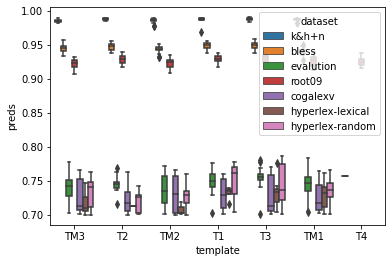

In [ ]:
df_plot_prov = df_plot[df_plot['preds']>0.7] #just take weight averages higher than 0.7
#to avoid the ones in which data didnt converge and visualize better.
#to see al data, comment above line, and change data below to 'df_plot'
sns.boxplot(data = df_plot_prov, x="template", y="preds", hue="dataset")

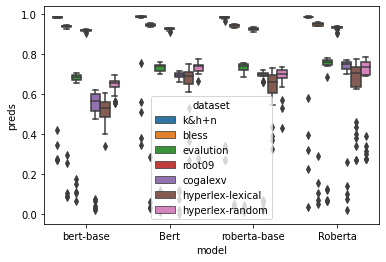

In [ ]:
#df_plot_prov = df_plot[df_plot['preds']>0.7]
sns.boxplot(data = df_plot, x="model", y="preds", hue="dataset")

Cogalexv weighed f1 of all categories compared to SOTA

In [ ]:
dfm_cogalexv = df_res_sotas_cogalexv.T
dfm_cogalexv = pd.melt(dfm_cogalexv)
dfm_cogalexv

,model,template,value
0,Bert,T1,0.770474
1,Bert,T1,0.680452
2,Bert,T1,0.715095
3,Bert,T1,0.563975
4,Bert,T1,0.690274
...,...,...,...
155,Sota,RelBert,0.794000
156,Sota,RelBert,0.616000
157,Sota,RelBert,0.702000
158,Sota,RelBert,0.505000


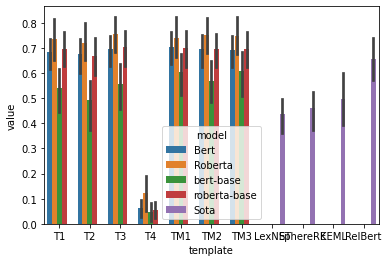

In [ ]:
sns.barplot(data=dfm_cogalexv, x= 'template', y='value', hue='model')

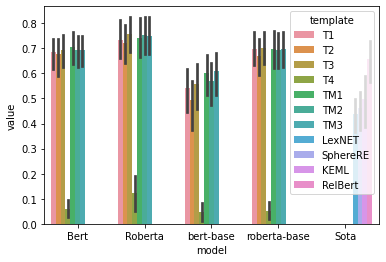

In [ ]:
sns.barplot(data=dfm_cogalexv, x= 'model', y='value', hue='template')

Bert Large experiments (the ones with better results and less variability on first sight), with T1(simplest template) compared to SOTA with bar plots. Here variability is not taken into account, just overall f1 weighed score.

In [ ]:
compare_f1_sota = pd.DataFrame()
for dataset in ['K&H+N', 'BLESS', 'EVALution', 'ROOT09']:
  df_prov = pd.melt(df_res_sotas[dataset].T)
  df_prov['dataset'] = dataset
  compare_f1_sota = pd.concat([df_prov, compare_f1_sota])



In [ ]:
compare_f1_sota

,model,template,value,dataset
0,Bert,T1,0.926534,ROOT09
1,Bert,T1,0.926418,ROOT09
2,Bert,T1,0.926258,ROOT09
3,Bert,T2,0.930032,ROOT09
4,Bert,T2,0.928549,ROOT09
...,...,...,...,...
91,Sota,SphereRE,0.989000,K&H+N
92,Sota,SphereRE,0.990000,K&H+N
93,Sota,RelBERT,NaN,K&H+N
94,Sota,RelBERT,NaN,K&H+N


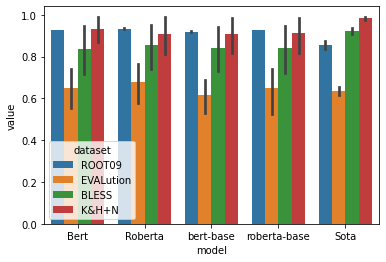

In [ ]:
sns.barplot(data=compare_f1_sota, x= 'model', y='value', hue='dataset')

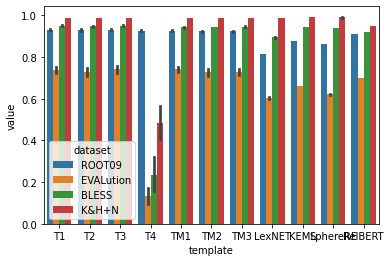

In [ ]:
sns.barplot(data=compare_f1_sota, x= 'template', y='value', hue='dataset')